### Imports

In [1]:
from IPython.display import clear_output, display # Para plots dinamicos no notebook
from sklearn.metrics import confusion_matrix
import os, h5py, torch, random, time, gc
from threading import Thread, Semaphore
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.ndimage import zoom # Caso precise reduzir a imagem
from logger import log
import torch.nn as nn
import seaborn as sns
import numpy as np

### Testar funcionamento dos algorítmos (em algum momento o kernel pode quebrar e isso daqui verifica se quebrou ou não)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Linear(10, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Modelo

In [ ]:
import torch
import torch.nn as nn

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SpectrogramCNN, self).__init__()

        conv1 = 128
        conv2 = 128
        conv3 = 16
        conv4 = 16
        conv5 = 16
        conv6 = 16

        first_linear = 323712
        linear_multpl = 57
        next_first_linear = int(first_linear*linear_multpl)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(conv1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.AvgPool2d(3),
            nn.Dropout(.2),

            nn.Conv2d(conv1, conv2, kernel_size=(20, 100), stride=1, padding=2),
            nn.BatchNorm2d(conv2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.AvgPool2d(3),
            nn.Dropout(.1),

            # nn.Conv2d(conv2, conv3, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(conv3),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.AvgPool2d(3),
            # nn.Dropout(.1),

            # nn.Conv2d(conv3, conv4, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(conv4),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.AvgPool2d(3),
            # nn.Dropout(.1),

            # nn.Conv2d(conv4, conv5, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(conv5),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.AvgPool2d(3),
            # nn.Dropout(.1),

            # nn.Conv2d(conv5, conv6, kernel_size=3, stride=1, padding=2),
            # nn.BatchNorm2d(conv6),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.AvgPool2d(3),
            # nn.Dropout(.1),
            
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(first_linear, num_classes)
            # nn.Linear(first_linear, next_first_linear),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.Dropout(0.3),
            # nn.Linear(next_first_linear, 128),
            # nn.LeakyReLU(negative_slope=0.01),
            # nn.Dropout(0.3),
            # nn.Linear(128, num_classes)

        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
    

caminho_das_musicas = "./musicas"
dir_base = caminho_das_musicas
dir_h5 = "h5"
estilos = os.listdir(dir_base)
ref_estilos = estilos.copy()
modelo = SpectrogramCNN(len(ref_estilos))
modelo.to(device)


SpectrogramCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(128, 128, kernel_size=(20, 100), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (9): Dropout(p=0.1, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=11, bias=True)
  )
)

### Separar train de test

In [4]:
def train_test_h5_labels(): # Utilizei esse pois precisava economizar na memória, então embaralho os patchs e n os dados
    dir_base = "musicas"
    dir_h5 = "h5"

    estilos = os.listdir(dir_base)
    ref_estilos = estilos.copy()

    h5_train_items_path = []
    train_labels = []

    h5_test_items_path = []
    test_labels = []

    for estilo in estilos:
        if estilo == "apenas_h5" or ".rar" in estilo:
            continue
        train_path = os.path.join(dir_base, estilo, dir_h5, "train")
        test_path = os.path.join(dir_base, estilo, dir_h5, "test")

        train_specs_names = os.listdir(train_path)
        for h5_spec in train_specs_names:
            h5_spec_path = os.path.join(train_path, h5_spec)
            h5_train_items_path.append(h5_spec_path)
            train_labels.append(ref_estilos.index(estilo))

        test_spec_names = os.listdir(test_path)
        for h5_spec in test_spec_names:
            h5_spec_path = os.path.join(test_path, h5_spec)
            h5_test_items_path.append(h5_spec_path)
            test_labels.append(ref_estilos.index(estilo))

    train_combinado = list(zip(h5_train_items_path, train_labels))
    test_combinado = list(zip(h5_test_items_path, test_labels))

    random.shuffle(train_combinado)
    random.shuffle(test_combinado)

    h5_train_items_path, train_labels = zip(*train_combinado)
    h5_test_items_path, test_labels = zip(*test_combinado)

    h5_train_items_path = list(h5_train_items_path)
    train_labels = list(train_labels)

    h5_test_items_path = list(h5_test_items_path)
    test_labels = list(test_labels)

    return h5_train_items_path, train_labels, h5_test_items_path, test_labels

### Ler h5

In [5]:
def read_h5_data(h5_item, zoom_factor=None, time_cut=None):
    with h5py.File(h5_item, "r") as f:
        data = f["data"]
        data = data[:]
        if time_cut is not None:
            data = data[:, :, data.shape[2]//time_cut:]
        
        if zoom_factor is not None:
            data = zoom(data, zoom_factor)

        return data

### Custom dataloader para RAM suficiente

In [6]:
class HighMemoryDataloader:

    def __init__(self, train_urls, train_labels, test_urls, test_labels, batch_size, device, zoom_factor=None, time_cut=None):
        self.train_urls: list = train_urls
        self.train_labels: list = train_labels
        self.test_urls: list = test_urls
        self.test_labels: list = test_labels

        self.device = device
        self.batch_size = batch_size
        self.zoom_factor = zoom_factor
        self.time_cut = time_cut

        self.actual_train_batch = 0
        self.actual_test_batch = 0

        self.max_train_batches = (len(train_urls)//batch_size) + 1
        self.max_test_batches = (len(test_urls)//batch_size) + 1

        self.ram_train_data = []
        self.ram_train_labels = self.train_labels.copy()
        self.ram_test_data = []
        self.ram_test_labels = self.test_labels.copy()
        self.load_dataset()

    def reconfig_batch(self, new_batch_size):
        self.batch_size  = new_batch_size

        self.max_train_batches = (len(self.train_urls)//self.batch_size) + 1
        self.max_test_batches = (len(self.test_urls)//self.batch_size) + 1

        self.actual_train_batch = 0
        self.actual_test_batch = 0

    def load_dataset(self):
        for i, t_url in enumerate(self.train_urls):
            i = i+1
            log(
                "Carregando variáveis de treino",
                f"{i}/{len(self.train_urls)}",
                i,
                len(self.train_urls)
            )
            data = read_h5_data(t_url, self.zoom_factor, self.time_cut)
            self.ram_train_data.append(data)

        log(
            "Carregando variáveis de treino",
            f"{i}/{len(self.train_urls)}",
            i,
            len(self.train_urls),
            end="\n"
        )

        for i, t_url in enumerate(self.test_urls):
            i = i+1
            log(
                "Carregando variáveis de teste",
                f"{i}/{len(self.test_urls)}",
                i,
                len(self.test_urls)
            )
            data = read_h5_data(t_url, self.zoom_factor, self.time_cut)
            self.ram_test_data.append(data)
        log(
            "Carregando variáveis de teste",
            f"{i}/{len(self.test_urls)}",
            i,
            len(self.test_urls),
            end="\n"
        )

    def get_train_batch(self):
        start_index = self.actual_train_batch*self.batch_size
        end_index = start_index + self.batch_size
        train_data = self.ram_train_data[start_index : end_index]
        train_labels = self.ram_train_labels[start_index : end_index]
        self.actual_train_batch = (self.actual_train_batch + 1) % (self.max_train_batches)

        batch_end = self.actual_train_batch == 0
        
        return torch.tensor(np.array(train_data), device=self.device), torch.tensor(np.array(train_labels), device=self.device), len(train_data) < self.batch_size
    
    def get_test_batch(self):
        start_index = self.actual_test_batch*self.batch_size
        end_index = start_index + self.batch_size
        test_data = self.ram_test_data[start_index : end_index]
        test_labels = self.ram_test_labels[start_index : end_index]
        self.actual_test_batch = (self.actual_test_batch + 1) % (self.max_test_batches)

        batch_end = self.actual_test_batch == 0
        
        return torch.tensor(np.array(test_data), device=self.device), torch.tensor(np.array(test_labels), device=self.device), len(test_data) < self.batch_size

    def train_len(self):
        return len(self.ram_train_data)
    
    def test_len(self):
        return len(self.ram_test_data)
    
    def shuffle(self):
        pares = list(zip(self.ram_train_data, self.ram_train_labels))
        random.shuffle(pares)
        self.ram_train_data, self.ram_train_labels = zip(*pares)
        self.ram_train_data = list(self.ram_train_data)
        self.ram_train_labels = list(self.ram_train_labels)

### Custom dataloader com threads


In [7]:
class ThreadDataloader:

  def __init__(self, train_urls: list, train_labels, test_urls: list, test_labels, batch_size, device, batch_multipl=3, zoom_factor=None, time_cut=None):
    self.train_urls = train_urls
    self.train_labels = train_labels
    self.test_urls = test_urls
    self.test_labels = test_labels

    self.zoom_factor = zoom_factor
    self.time_cut = time_cut
    self.stop_threads = False
    self.device = device

    self.loaded_train_data = []
    self.loaded_test_data = []
    self.loaded_train_labels = []
    self.loaded_test_labels = []

    self.batch_size = batch_size
    self.max_train_batches = len(train_urls)//batch_size
    self.max_test_batches = len(test_urls)//batch_size
    self.actual_train_batch = 0
    self.actual_test_batch = 0
    self.max_len = self.batch_size*batch_multipl
    self.train_semas = Semaphore(len(train_urls))
    self.test_semas = Semaphore(len(test_urls))
    self.mutex = Semaphore()

  def free_train(self):
    self.stop_threads = True
    self.mutex.release()
    self.train_semas.release()

  def free_test(self):
    self.stop_threads = True
    self.mutex.release()
    self.test_semas.release()


  def stop(self):
    self.free_train()
    self.free_test()

  def collect_train(self):
    while not self.stop_threads:
      for train_url, train_label in zip(self.train_urls, self.train_labels):
        if self.stop_threads:
          break
        data = read_h5_data(train_url, self.zoom_factor, self.time_cut)
        self.mutex.acquire()
        self.loaded_train_data.append(data)
        self.loaded_train_labels.append(train_label)
        self.mutex.release()
        self.train_semas.acquire()

  def collect_test(self):
    while not self.stop_threads:
      for test_url, test_label in zip(self.test_urls, self.test_labels):
        if self.stop_threads:
          break
        data = read_h5_data(test_url, self.zoom_factor, self.time_cut)
        self.mutex.acquire()
        self.loaded_test_data.append(data)
        self.loaded_test_labels.append(test_label)
        self.mutex.release()
        self.test_semas.acquire()

  def get_train_batch(self):
    while len(self.loaded_train_data) < self.batch_size:
      time.sleep(0.5)

    self.mutex.acquire()
    train_data = []
    train_labels = []
    for _ in range(self.batch_size):
      train_data.append(self.loaded_train_data.pop(0))
      train_labels.append(self.loaded_train_labels.pop(0))
      self.train_semas.release()

    self.mutex.release()
    self.actual_train_batch = (self.actual_train_batch + 1) % (self.max_train_batches)

    batch_end = self.actual_train_batch == 0

    return torch.tensor(np.array(train_data), device=self.device), torch.tensor(np.array(train_labels), device=self.device), batch_end

  def get_test_batch(self):
    while len(self.loaded_test_data) < self.batch_size:
      time.sleep(0.5)

    self.mutex.acquire()
    test_data = []
    test_labels = []
    for _ in range(self.batch_size):
      test_data.append(self.loaded_test_data.pop(0))
      test_labels.append(self.loaded_test_labels.pop(0))
      self.test_semas.release()

    self.mutex.release()
    self.actual_test_batch = (self.actual_test_batch + 1) % (self.max_test_batches)

    batch_end = self.actual_test_batch == 0

    return torch.tensor(np.array(test_data), device=self.device), torch.tensor(np.array(test_labels), device=self.device), batch_end

  def train_len(self):
   self.mutex.acquire()
   length = len(self.loaded_train_data)
   self.mutex.release()
   return length

  def test_len(self):
   self.mutex.acquire()
   length = len(self.loaded_test_data)
   self.mutex.release()
   return length


### Função de treino

In [8]:
def train_step(modelo: SpectrogramCNN, dataloader: ThreadDataloader | HighMemoryDataloader):
    modelo.train()
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    stop_train = False

    while not stop_train:
        if isinstance(dataloader, ThreadDataloader):
            while len(dataloader.loaded_train_data) < dataloader.batch_size:
                log(
                    f"Treino {dataloader.actual_train_batch}/{dataloader.max_train_batches}",
                    f"Coletando {dataloader.train_len()} items carregados em memória - Loss: {total_loss/(dataloader.actual_train_batch if dataloader.actual_train_batch != 0 else dataloader.max_train_batches)}",
                    dataloader.actual_train_batch,
                    dataloader.max_train_batches,
                    progress_char="+",
                    void_char=" "
                )
                time.sleep(0.5)

        batch_data, batch_labels, stop_train = dataloader.get_train_batch()
        # batch_data = batch_data.permute(0, 2, 1, 3)

        optimizer.zero_grad()
        outputs = modelo(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total += batch_labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_labels).sum().item()

        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        log(
          f"Treino {dataloader.actual_train_batch}/{dataloader.max_train_batches}",
          f"{len(batch_data)} batch_size - Loss: {total_loss/(dataloader.actual_train_batch if dataloader.actual_train_batch != 0 else dataloader.max_train_batches)}",
          dataloader.actual_train_batch,
          dataloader.max_train_batches,
          progress_char="+",
          void_char=" "
        )

    avg_loss = total_loss / dataloader.max_train_batches
    log(
		f"Treino {dataloader.actual_train_batch}/{dataloader.max_train_batches}",
		f"{len(batch_data)} batch_size - Loss: {total_loss/dataloader.max_train_batches}",
		dataloader.actual_train_batch,
		dataloader.max_train_batches,
		progress_char="+",
		void_char=" "
	)

    return avg_loss, y_true, y_pred, 100 * correct / total

### Função de teste

In [9]:
def test_step(modelo: SpectrogramCNN, dataloader: ThreadDataloader | HighMemoryDataloader):
    modelo.eval()
    correct = 0
    total = 0
    total_loss = 0
    y_true = []
    y_pred = []
    stop_test = False

    while not stop_test:
        with torch.no_grad():
            if isinstance(dataloader, ThreadDataloader):
                while len(dataloader.loaded_test_data) < dataloader.batch_size:
                    log(
                        f"Teste {dataloader.actual_test_batch}/{dataloader.max_test_batches}",
                        f"Coletando {dataloader.test_len()} items carreagados em memória - Loss {total_loss/(dataloader.actual_test_batch if dataloader.actual_test_batch != 0 else dataloader.max_test_batches)}",
                        dataloader.actual_test_batch,
                        dataloader.max_test_batches,
                        progress_char="H",
                        void_char="-"
                    )
                    time.sleep(0.5)
            
            batch_data, batch_labels, stop_test = dataloader.get_test_batch()
            # batch_data = batch_data.permute(0, 2, 1, 3)
            outputs = modelo(batch_data)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            y_true.extend(batch_labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            log(
                f"Teste {dataloader.actual_test_batch}/{dataloader.max_test_batches}",
                f"{len(batch_data)} batch_size - Loss {total_loss/(dataloader.actual_test_batch if dataloader.actual_test_batch != 0 else dataloader.max_test_batches)}",
                dataloader.actual_test_batch,
                dataloader.max_test_batches,
                progress_char="H",
                void_char="-"
            )

    log(
        f"Teste {dataloader.actual_test_batch}/{dataloader.max_test_batches}",
        f"{len(batch_data)} batch_size - Loss {total_loss/(dataloader.actual_test_batch if dataloader.actual_test_batch != 0 else dataloader.max_test_batches)}",
        dataloader.actual_test_batch,
        dataloader.max_test_batches,
        progress_char="H",
        void_char="-"
    )

    avg_test_loss = total_loss / dataloader.max_test_batches
    return avg_test_loss, y_true, y_pred, 100 * correct / total

### Treino e teste sendo efetuados com thead dataloader

In [10]:
# torch.cuda.empty_cache()

In [11]:
# losses = []
# accurracy_test = []
# epochs = []
# plt.ion()
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
# line_losses, = ax1.plot(epochs, losses, label='Train Loss')
# line_accurracy_test, = ax2.plot(epochs, accurracy_test, label='Test Loss')


# print(device)

# zoom_factor = (1, 1, 1)
# zoom_factor = None
# batch_size = 15
# time_cut = 2
# time_cut = None

# h5_train_items_path, train_labels, h5_test_items_path, test_labels = train_test_h5_labels()
# dataloader = ThreadDataloader(h5_train_items_path, train_labels, h5_test_items_path, test_labels, batch_size, device, zoom_factor=zoom_factor, time_cut=time_cut, batch_multipl=5)
# # dataloader.collect_train()
# collect_train_thread = Thread(target=dataloader.collect_train)
# collect_test_thread = Thread(target=dataloader.collect_test)
# collect_train_thread.start()
# collect_test_thread.start()

# print("Aguardando 10s para acumulo inicial de dados")
# # time.sleep(10)

# # print(modelo, flush=True)

# optimizer = torch.optim.AdamW(modelo.parameters(), lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# num_epochs = 1000
# for epoch in range(1, num_epochs):
#     print(f"Epoca: {epoch}", flush=True)
#     if len(epochs) < 30:
#         epochs.append(epoch+1)

#     avg_loss = train_step(modelo, dataloader)
#     losses.append(avg_loss)
#     if len(losses) > 30:
#         losses.pop(0)
#     line_losses.set_xdata(epochs)
#     line_losses.set_ydata(losses)
#     ax1.relim()
#     ax1.autoscale()
#     ax1.set_title("Training Loss")
#     ax1.set_xlabel("Epoch")
#     ax1.set_ylabel("Loss")

#     clear_output(wait=True)
#     display(fig)

#     total_loss, y_true, y_pred, correct, total = test_step(modelo, dataloader)

#     avg_test_loss = total_loss / len(h5_test_items_path)
#     accuracy = 100 * correct / total
#     accurracy_test.append(accuracy)
#     if len(accurracy_test) > 30:
#         accurracy_test.pop(0)
#     line_accurracy_test.set_xdata(epochs)
#     line_accurracy_test.set_ydata(accurracy_test)
#     ax2.relim()
#     ax2.autoscale()
#     ax2.set_title("Testing accuracy")
#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Accuracy")

#     ax3.clear()
#     ax3.set_title("Confusion Matrix")

#     cm = confusion_matrix(y_true, y_pred)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax3,
#                 xticklabels=ref_estilos, yticklabels=ref_estilos, cbar=False)
#     ax3.set_xlabel("Predicted")
#     ax3.set_ylabel("True")


#     clear_output(wait=True)
#     display(fig)

#     print(f"Epoch {epoch}, Loss:: Train {avg_loss:.4f} Test {avg_test_loss:.4f}", flush=True)
#     print(f"Test Accuracy: {accuracy:.2f}%", flush=True)
#     torch.save(modelo.state_dict(), f"modelo.pth")

In [12]:
# dataloader.stop()
# collect_train_thread.join()
# collect_test_thread.join()
# print("Threads finalizadas")

### Treino e teste sendo efetuados com memoria suficientemente grande

In [13]:
torch.cuda.empty_cache()

cuda


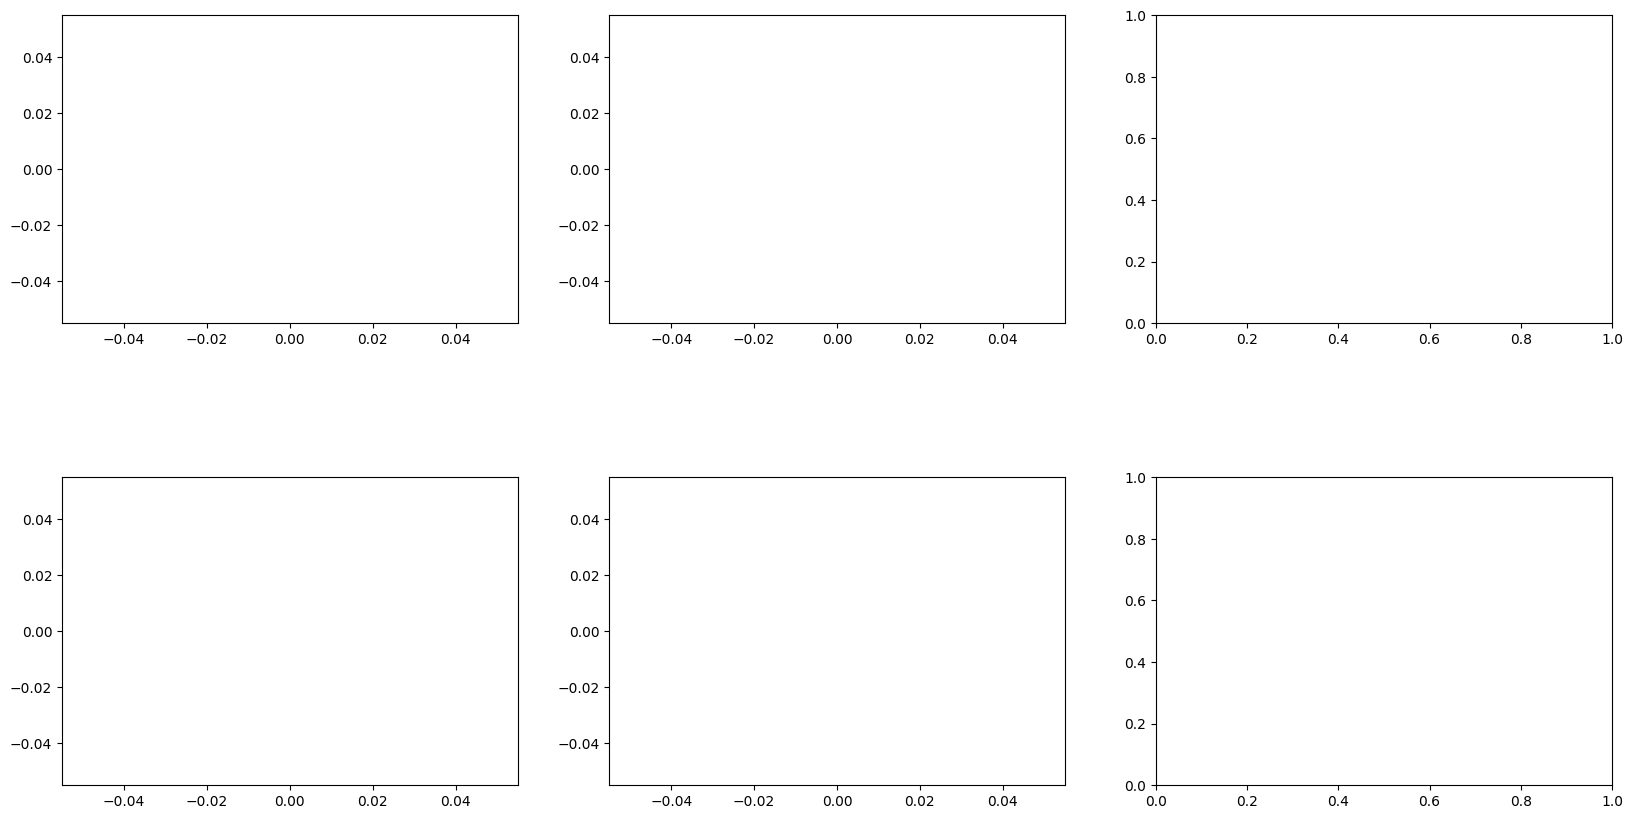

In [14]:
train_losses = []
test_losses = []

accuracy_train = []
accuracy_test = []

epochs = []

plt.ion()
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
(ax1, ax2, ax3), (ax4, ax5, ax6) = ax

line_train_losses, = ax1.plot(epochs, train_losses, label='Train Loss')
line_train_accuracy, = ax2.plot(epochs, accuracy_train, label="Train accuracy")

line_test_losses, = ax4.plot(epochs, test_losses, label='Test Loss')
line_test_accuracy, = ax5.plot(epochs, accuracy_test, label='Test accuracy')

print(device)

In [15]:
zoom_factor = (1, 1, 1)
zoom_factor = None
batch_size = 10
time_cut = 2
time_cut = None

h5_train_items_path, train_labels, h5_test_items_path, test_labels = train_test_h5_labels()

dataloader = HighMemoryDataloader(h5_train_items_path, train_labels, h5_test_items_path, test_labels, batch_size, device, zoom_factor=zoom_factor, time_cut=time_cut)

Carregando variáveis de treino  [>>>>>>>>>>>>>>>>>>>>]  6165/6165                                                                                                                                                                                                                 
Carregando variáveis de teste  [>>>>>>>>>>>>>>>>>>>>]  1545/1545                                                                                                                       


In [16]:
optimizer = torch.optim.AdamW(modelo.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []

accuracy_train = []
accuracy_test = []

epochs = []

gc.collect()
torch.cuda.empty_cache()
batch_size = 20
dataloader: HighMemoryDataloader
dataloader.reconfig_batch(batch_size)

num_epochs = 1000
for epoch in range(1, num_epochs):
    print(f"Epoca: {epoch}", flush=True)
    epochs.append(epoch+1)

    avg_loss, y_true, y_pred, accuracy = train_step(modelo, dataloader)

    train_losses.append(avg_loss)
    line_train_losses.set_xdata(epochs)
    line_train_losses.set_ydata(train_losses)

    accuracy_train.append(accuracy)
    print(line_train_accuracy)
    line_train_accuracy.set_xdata(epochs)
    line_train_accuracy.set_ydata(accuracy_train)
    
    if len(train_losses) >= 2:
        line_train_losses.set_color("green" if avg_loss <= train_losses[-2] else "red")
        line_train_accuracy.set_color("green" if accuracy >= accuracy_train[-2] else "red")


    ax1.relim()
    ax1.autoscale()
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")

    ax2.relim()
    ax2.autoscale()
    ax2.set_title("Training Accuracy")
    ax2.set_xlabel("Epoc")
    ax2.set_ylabel("Accuracy")

    ax3.clear()
    ax3.set_title("Training Confusion Matrix")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax3, xticklabels=ref_estilos, yticklabels=ref_estilos, cbar=False)
    ax3.set_xlabel("Predicted")
    ax3.set_ylabel("True")

    clear_output(wait=True)
    display(fig)

    avg_test_loss, y_true, y_pred, accuracy = test_step(modelo, dataloader)

    test_losses.append(avg_test_loss)
    line_test_losses.set_xdata(epochs)
    line_test_losses.set_ydata(test_losses)

    accuracy_test.append(accuracy)
    line_test_accuracy.set_xdata(epochs)
    line_test_accuracy.set_ydata(accuracy_test)

    if len(accuracy_test) >= 2:
        line_test_losses.set_color("green" if avg_test_loss <= test_losses[-2] else "red")
        line_test_accuracy.set_color("green" if accuracy >= accuracy_test[-2] else "red")

    ax4.relim()
    ax4.autoscale()
    ax4.set_title("Testing Loss")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Loss")

    ax5.relim()
    ax5.autoscale()
    ax5.set_title("Testing accuracy")
    ax5.set_xlabel("Epoch")
    ax5.set_ylabel("Accuracy")

    ax6.clear()
    ax6.set_title("Testing Confusion Matrix")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax6, xticklabels=ref_estilos, yticklabels=ref_estilos, cbar=False)
    ax6.set_xlabel("Predicted")
    ax6.set_ylabel("True")


    clear_output(wait=True)
    display(fig)

    print(f"Epoch {epoch}, Loss:: Train {avg_loss:.4f} Test {avg_test_loss:.4f}", flush=True)
    print(f"Test Accuracy: {accuracy:.2f}%", flush=True)
    torch.save(modelo.state_dict(), f"modelo.pth")

Epoca: 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x323712 and 64x11)